In [3]:
import os
import random
import sys

from functools import reduce
from numpy import subtract, floor_divide
    
from PIL import Image, ImageDraw, ImageFont

In [4]:
# globals
CHARSET_SIZE = 0
# DATA_DIR = os.environ.get('PONCO_DATA_DIR')
# FONT_DIR = os.environ.get('PONCO_FONT_DIR')

FONT_DIR = '/home/macermak/code/thesis/char-generator/fonts'  # FIXME
DATA_DIR = '/home/macermak/code/thesis/char-generator/dataset'  # FIXME

if not FONT_DIR or not DATA_DIR:
    print("FONT_DIR or DATA_DIR environment variable is missing", file=sys.stderr)
    # exit(1)

# Create directories if not exist
if not os.path.isdir(FONT_DIR):
    os.mkdir(FONT_DIR)
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

In [5]:
def estimate_font_size(ttf, text, fit_size, font_size=20, eps=8):
    font = ImageFont.truetype(font=ttf, encoding='utf-8', size=font_size)

    w, h = font.getsize(text)
    _err = max(fit_size) - max(w, h)
    
    while abs(_err) > eps:
        w, h = font.getsize(text)
        _err = max(fit_size) - max(w, h)
        
        font_size += 1 if _err > 0 else -1
        font = ImageFont.truetype(font=ttf, encoding='utf-8', size=int(font_size))
    
    return font

In [29]:
def load_char_set(fpath='simple-charset.txt') -> list:
    """Load characters that are allowed from the charset.txt file."""
    with open(fpath) as f:  # FIXME: use the full charset by default
        chars = f.read().split()

    global CHARSET_SIZE
    CHARSET_SIZE = len(chars)

    return chars

In [7]:
def load_font_set() -> list:
    """Walk through the default font directory and search for font files."""
    import re
    fnames = []
    for root, _, files in os.walk(FONT_DIR):
        fnames.extend(os.path.join(root, f) for f in files if re.match(r'(.+)\.[odtfOTF]{3}', f))

    return fnames

In [141]:
def get_near_dim_2d(number, mode='wide') -> tuple:
    """Try to factor the number into two similiar dimensions."""
    import numpy as np
    if number <= 2:
        return (number, 1)
        
    shape = [2, 2]
    while np.prod(shape) < number:
        shape[np.argmin(shape)] += 1
        
    return tuple(sorted(shape, reverse=(mode == 'wide')))

In [123]:
def create_whiteboard(shape=None, n_samples=None, color='#f4f4f4', sample_size=(32, 32)) -> Image.Image:
    """Computes and Creates white board (background) for the given font."""
    
    if not any([n_samples, shape]):
        print("Either `n_samples` or `shape` must be provided.")
        return
    
    if shape is None:
        assert len(n_samples) == 2, "expected `n_samples` argument to be 2-D vector, but is %i-D vector" % len(n_samples)
        bg_size = (n_samples[0] * sample_size[0], n_samples[1] * sample_size[1])
    else:
        assert len(shape) == 2, "expected `shape` argument to be 2-D vector, but is %i-D vector" % len(shape)
        bg_size = shape

    return Image.new(mode='RGBA', size=bg_size, color=color)

In [9]:
def get_text_loc_in_sample(text, font: "ImageFont.font", sample_size, offset='random'):
    """Calculates location of text on the given sample background."""
    fo_x, fo_y = font.getoffset(text)
    if offset == 'random':
        # add a little bit of entropy
        rand_factor = min(sample_size) // 10
        font_offset = (
                fo_x + random.randint(-rand_factor, rand_factor),
                fo_y + random.randint(-rand_factor, rand_factor),
        )
        
    # location of char in the sample
    char_loc = reduce(subtract, (sample_size, font.getsize(text), font_offset))
    char_loc = floor_divide(char_loc, 2)
    
    return char_loc

In [133]:
def create_sprites(charset: list, fontset: list, sample_size=(32, 32)):
    """Create sprites for each font provided in fontset and saves it as .png into IMG_DIR.
    Characters given by charset are drawn on a spritesheet.
    """
    import re

    if not fontset:
        print("Empty argument provided: fontset - ", fontset, file=sys.stderr)

    n_samples = get_near_dim_2d(len(charset))
    board = create_whiteboard(n_samples=n_samples, sample_size=sample_size)
    sprites_dir = "{path}/sprites".format(path=DATA_DIR)
    # Make sure sprites directory exists
    if not os.path.isdir(sprites_dir):
        os.mkdir(sprites_dir)

    for font_file in fontset:
        font_name = re.search(r"([^/]+)\.(\w+)$", font_file).group(1)
        board_name = "{path}/{ttf}-board.png".format(
                path=sprites_dir,
                ttf=font_name)
        if os.path.isfile(board_name):
            print('Skipping', board_name)
            continue

        print("Creating spritesheet", board_name, "...") 
        font_board = board.copy()
        try:
            font = estimate_font_size(
                    ttf=font_file,
                    text='H',  # for sake of performance, assume that what works
                                # for H, works for everything else
                    fit_size=(32, 32),
                    eps=max(sample_size) // 10
                    )
        except OSError as e:
            print("Skipping", font_file, e.args)
            
        draw = ImageDraw.Draw(font_board)

        init_pos = (0, 0)
        for char in charset:
            # position of char in the sample
            char_loc = get_text_loc_in_sample(text=char, font=font, sample_size=sample_size)
            
            # position of char on the board
            char_pos = init_pos + char_loc
            draw.text(
                    xy=char_pos,
                    text=char,
                    font=font,
                    fill="black"
                    )

            if init_pos[0] + sample_size[0] >= board.size[0]:
                init_pos = (0, init_pos[1] + sample_size[1])
            else:
                init_pos = (init_pos[0] + sample_size[0], init_pos[1])

        # save the board
        font_board.save(fp=board_name)
        print('Written', board_name)

In [93]:
def create_char_image(char, font_file, sample_size=(32, 32), bgcolor='#f6f6f6', fontcolor='black'):
    """Generate image of given size and font for each character."""
    try:
        font = estimate_font_size(
                ttf=font_file,
                text=char,  # for sake of performance, assume that what works
                           # for H, works for everything else
                fit_size=(32, 32),
                eps=max(sample_size) // 10
                )
    except OSError as e:
        print("Skipping", font_file, e.args)
        raise OSError from e

    char_bg = Image.new(mode='RGB', color=bgcolor, size=sample_size)
    draw = ImageDraw.Draw(char_bg)
    
    char_loc = get_text_loc_in_sample(text=char, font=font, sample_size=sample_size)
    draw.text(
            xy=char_loc,
            text=char,
            font=font,
            fill=fontcolor
            )
    
    return char_bg

In [73]:
def create_charset_dir(charset, prefix=None, dir_name='charset', create_prefix_dir=False):
    """Create charset directory with structure matching Keras directory model."""
    import os
    import sys
    
    if prefix is not None and not os.path.isdir(prefix):
        if not create_prefix_dir:
            print("Directory {dir} passed as `prefix` does not exist. Use `create_prefix_dir=True` to create prefix directory.",
                  file=sys.stderr)
            return
        else:
            os.mkdir(prefix)
            
    if prefix is None:
        prefix = '.'
    elif prefix.endswith('/'):
        # Strip the last slash from prefix path
        prefix = prefix[:-1]
        
    charset_dir = "{prefix}/charset".format(prefix=prefix)
    if os.path.isdir(charset_dir):
        print('Directory %s already exists.' % charset_dir, file=sys.stderr)
        return
            
    os.mkdir(charset_dir)
    
    for char in charset:
        char_ascii = ord(char)
        char_dir = "{charset_dir}/{char_dir}".format(charset_dir=charset_dir, char_dir=char_ascii)
        os.mkdir(char_dir)
        
    return charset_dir 

In [84]:
def create_and_save_charsets(charset, fontset, sample_size=(32, 32), bgcolor='#f6f6f6', fontcolor='black'):
    """Create char images from charset for each font in fontset."""
    import re
    charset_dir = create_charset_dir(charset=charset, prefix=DATA_DIR, create_prefix_dir=True)
        
    for font_file in fontset:
        font_name = re.search(r"([^/]+)\.(\w+)$", font_file).group(1)
        for char in charset:
            try:
                char_img = create_char_image(char, font_file, sample_size, bgcolor, fontcolor)
            except OSError:
                # Skip the font completely
                break
            char_img_path = "{charset_dir}/{char_dir}/{font_name}.png".format(
                charset_dir=charset_dir,
                char_dir=ord(char),  # The directory structure expects char ordinal
                font_name=font_name
            ) 
            char_img.save(fp=char_img_path, formet='png')

## Tests

In [14]:
import unittest

In [139]:
import os
import sys
import tempfile

class GeneratorTests(unittest.TestCase):
    """Class containing tests for character generator."""
    TEST_CHARSET = ['A', 'a', '0', '.', '&', '^']
    
    def test_load_charset(self):
        fd, f_path = tempfile.mkstemp()
        for char in self.TEST_CHARSET:
            os.write(fd, "{}\n".format(char).encode())
        os.close(fd)
        loaded_charset = load_char_set(f_path)
        
        self.assertSequenceEqual(self.TEST_CHARSET, loaded_charset)
    
    def test_get_near_dim(self):
        number = 210
        shape = get_near_dim_2d(number, mode='wide')
        
        self.assertEqual(shape, (15, 14))
    
    def test_create_charset_dir_correct_path(self):
        """Check if the path to the new directory has been returned."""
        prefix = tempfile.mkdtemp()
        charset_dir = create_charset_dir(self.TEST_CHARSET, prefix, create_prefix_dir=True)
        
        self.assertTrue(charset_dir.startswith(prefix))
                          
    def test_create_charset_dir(self):
        """Check if the new directory contains subdirectories matching the test_charset."""
        prefix = tempfile.mkdtemp()
        charset_dir = create_charset_dir(self.TEST_CHARSET, prefix, create_prefix_dir=True)
        charset_ascii = set(ord(c) for c in self.TEST_CHARSET)
        subdirs = set(int(dir_name) for dir_name in os.listdir(charset_dir))
        
        self.assertEqual(subdirs, charset_ascii)

In [142]:
suite = unittest.defaultTestLoader.loadTestsFromTestCase(GeneratorTests)
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.003s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

## Execution

In [48]:
charset = load_char_set()
fontset = load_font_set()

font_file = '/home/macermak/code/thesis/char-generator/fonts/Inconsolata/Inconsolata.otf'

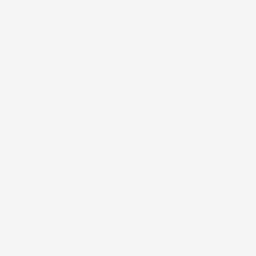

In [132]:
create_whiteboard(n_samples=get_near_dim_2d(len(charset)))

In [135]:
# Create a fontboard to visualize an arbitrary font
create_sprites(charset=charset, fontset=[font_file])

Creating spritesheet /home/macermak/code/thesis/char-generator/dataset/sprites/Inconsolata-board.png ...
Written /home/macermak/code/thesis/char-generator/dataset/sprites/Inconsolata-board.png


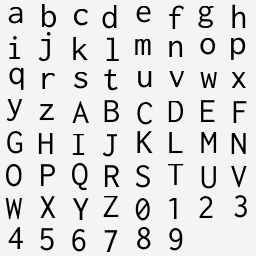

In [136]:
Image.open('/home/macermak/code/thesis/char-generator/dataset/sprites/Inconsolata-board.png')

In [81]:
%pdb off

Automatic pdb calling has been turned OFF


In [85]:
create_and_save_charsets(charset=charset, fontset=fontset)

Skipping /home/macermak/code/thesis/char-generator/fonts/GFS_BODONI/MACOSX/GFS_BODONI_OT/._GFSBodoniBold.otf ('unknown file format',)
Skipping /home/macermak/code/thesis/char-generator/fonts/GFS_BODONI/MACOSX/GFS_BODONI_OT/._GFSBodoni.otf ('unknown file format',)
Skipping /home/macermak/code/thesis/char-generator/fonts/GFS_BODONI/MACOSX/GFS_BODONI_OT/._GFSBodoniBoldIt.otf ('unknown file format',)
Skipping /home/macermak/code/thesis/char-generator/fonts/GFS_BODONI/MACOSX/GFS_BODONI_OT/._GFSBodoniIt.otf ('unknown file format',)
Skipping /home/macermak/code/thesis/char-generator/fonts/GFS_DIDOT/MACOSX/GFS_DIDOT_TT/._GFSDidotBold.ttf ('unknown file format',)
Skipping /home/macermak/code/thesis/char-generator/fonts/GFS_DIDOT/MACOSX/GFS_DIDOT_TT/._GFSDidot.ttf ('unknown file format',)
Skipping /home/macermak/code/thesis/char-generator/fonts/GFS_DIDOT/MACOSX/GFS_DIDOT_TT/._GFSDidotItalic.ttf ('unknown file format',)
Skipping /home/macermak/code/thesis/char-generator/fonts/GFS_DIDOT/MACOSX/GFS